In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import multi_agent_reinforcement_learning
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

In [95]:

cities = ['san_francisco', 'nyc_brooklyn', 'shenzhen_downtown_west', 'washington_dc']
city = cities[0]
with open(f"./data/scenario_{city}.json") as f:
    data = json.loads(f.read())

In [96]:
df = pd.DataFrame(data["demand"])

In [6]:
df

,time_stamp,origin,destination,demand,travel_time,price
0,1185,5,9,0.066667,18,33.3
1,1185,7,9,0.133333,7,13.3
2,1185,8,9,1.466667,10,13.5
3,1185,9,7,0.266667,10,14.6
4,1185,8,7,1.333333,10,12.3
...,...,...,...,...,...,...
5365,1259,6,5,0.200000,16,22.7
5366,1259,4,5,0.066667,6,11.6
5367,1259,4,7,0.133333,10,16.5
5368,1259,7,3,0.066667,11,18.0


In [7]:
(df["price"] / df["travel_time"]).min()

1.155

In [8]:
df["price"].max() / df["travel_time"].max()

1.261818181818182

In [9]:
json_start = 19*60
json_tstep = 3

In [10]:
df["converted_time_stamp"] = (df["time_stamp"]- 19 * 60) // 3

In [11]:
i = 5
j = 9
for step in range(20):
    loc_time_mask = (
        (df["origin"] == i)
        & (df["destination"] == j)
        & (
            (
                df["time_stamp"]
                - 19 * 60
            )
            // 3
            == step
        )
    )
    print(df.loc[loc_time_mask, "travel_time"].mean(), step)


17.0 0
17.0 1
17.0 2
17.0 3
17.0 4
10.0 5
10.0 6
10.0 7
10.0 8
10.0 9
nan 10
nan 11
nan 12
nan 13
nan 14
18.0 15
18.0 16
18.0 17
18.0 18
18.0 19


In [12]:
(df["travel_time"] - 19 * 60) // 3

0      -374
1      -378
2      -377
3      -377
4      -377
       ... 
5365   -375
5366   -378
5367   -377
5368   -377
5369   -378
Name: travel_time, Length: 5370, dtype: int64

In [13]:
df.loc[loc_time_mask, "travel_time"]

300    18
325    18
350    18
Name: travel_time, dtype: int64

In [14]:
reb_df = pd.DataFrame(data["rebTime"])
reb_df = reb_df[reb_df["time_stamp"]==19]

In [15]:
df_new = df.merge(reb_df, on=["origin", "destination"])

In [16]:
smf.ols(formula="price ~ reb_time", data=df_new).fit()

In [17]:
org, dest = 5, 9
test = df[(df["origin"] == org) & (df["destination"] == dest)] # 3.466

In [18]:
((test.travel_time * test.demand * 2/3) / (test.demand * 2)).round().unique()

array([6., 3., 7., 4., 5.])

# Simple summary stats

In [19]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [20]:
df_org_dest.head()

origin destination price           demand travel_time
                     count   mean      mean        mean
0      0           2    15  10.00  0.066667         4.0
1      0           8    15  46.40  0.066667        31.0
2      1           5    15  16.50  0.133333        10.0
3      1           7    30  31.95  0.066667        18.5
4      2           0    15  10.50  0.066667         5.0

In [21]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [22]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price,converted_time_stamp
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,1230.296089,6.237430,5.737430,0.385661,11.977654,18.692179,29.765363
std,51.039938,2.014673,2.372853,0.496670,5.371075,8.274623,17.011135
min,1140.000000,0.000000,0.000000,0.066667,3.000000,10.000000,0.000000
25%,1186.000000,5.000000,4.000000,0.066667,9.000000,12.800000,15.000000
50%,1232.000000,7.000000,6.000000,0.133333,11.000000,15.700000,30.000000
75%,1273.000000,8.000000,8.000000,0.466667,15.000000,22.700000,44.000000
max,1319.000000,9.000000,9.000000,2.333333,55.000000,69.400000,59.000000


In [23]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [0 1 2 3 4 5 6 7 8 9]
Destination nodes: [0 1 2 3 4 5 6 7 8 9]


# Grid analysis

In [24]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

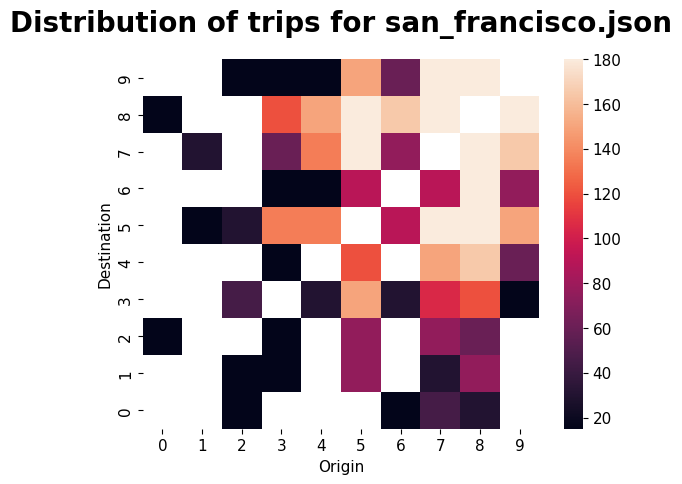

In [25]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title(f"Distribution of trips for {city}.json")
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.savefig(f"./figs/DistributionOfTrips_{city}")
plt.show()

In [26]:
# mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])
# plt.figure(figsize=(10, 8))
# sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
# plt.title('Heatmap of Mean Demand in Each Grid')
# plt.xlabel('Longitude Grid')
# plt.ylabel('Latitude Grid')
# plt.show()

# Travel time analysis

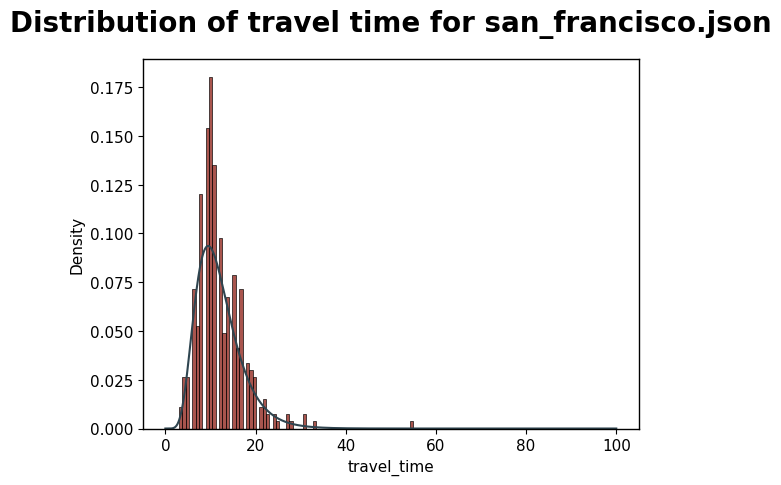

In [27]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of travel time for {city}.json")
plt.savefig(f"./figs/TravelTimeDist_{city}")
plt.show()

# Price analysis

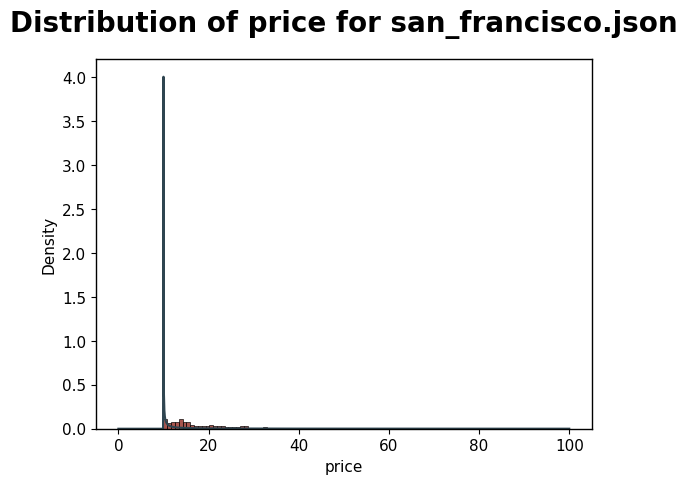

In [28]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of price for {city}.json")
plt.savefig(f"./figs/DistOfPrice_{city}")
plt.show()

In [29]:
pred_df = df.copy()

In [30]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [31]:
sc = StandardScaler()

In [32]:
glm_model = smf.glm(formula="price ~ -1 + travel_time", data=pred_df, family=sm.families.Gaussian())
fitted_glm = glm_model.fit()

In [33]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5369
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          7.6922
Method:                          IRLS   Log-Likelihood:                -13097.
Date:                Tue, 02 Jan 2024   Deviance:                       41299.
Time:                        12:38:24   Pearson chi2:                 4.13e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
travel_time     1.5429      0.003    535.108      0.000       1.537       1.549
===============================================================================
"""

<Axes: xlabel='price', ylabel='Density'>

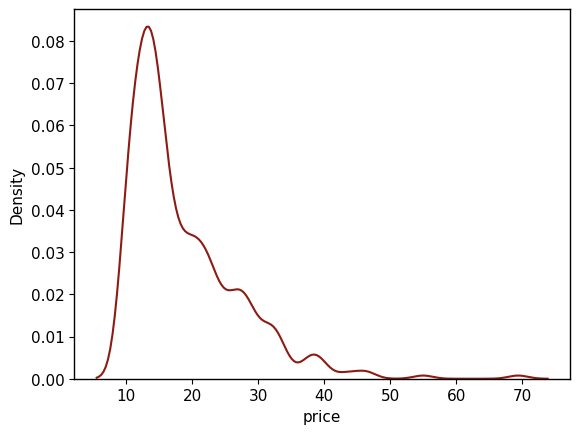

In [34]:
sns.kdeplot(df["price"])

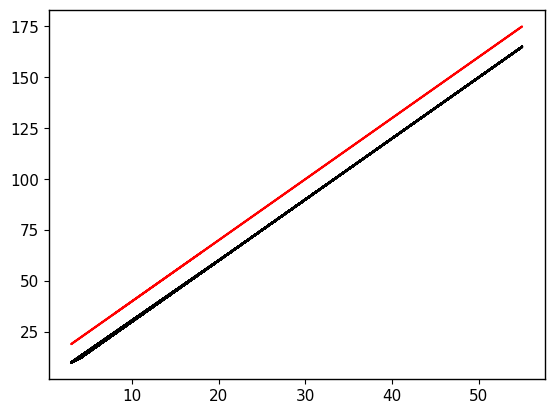

In [35]:
trans_price = df["travel_time"].values * 3
trans_price[trans_price < 10] = 10
plt.figure()
plt.plot(df["travel_time"], trans_price, color="black", label="RL")
plt.plot(df["travel_time"], 10 + df["travel_time"]*3, color="red", label="RL")
plt.show()


In [36]:
from statsmodels.stats.outliers_influence import summary_table

In [71]:
fitted_values = fitted_glm.get_prediction().summary_frame(alpha=0.05)
fitted_values = fitted_values.sort_values("mean")

In [97]:
df = df.merge(fitted_values, left_index=True, right_index=True)

In [127]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5369
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                          7.6922
Method:                          IRLS   Log-Likelihood:                -13097.
Date:                Tue, 02 Jan 2024   Deviance:                       41299.
Time:                        15:04:57   Pearson chi2:                 4.13e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9996
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
travel_time     1.5429      0.003    535.108      0.000       1.537       1.549
===============================================================================
"""

In [128]:
10/1.5

6.666666666666667

In [121]:
df.loc[df["new_mean"] == 10, "travel_time"]

21      6
46      6
71      6
96      6
121     6
       ..
5312    6
5333    6
5339    6
5360    6
5366    6
Name: travel_time, Length: 540, dtype: int64

In [101]:
new_fitted = fitted_values["mean"].copy()
df["new_mean"] = df["mean"].copy()
df.loc[df["new_mean"] < 10, "new_mean"] = 10

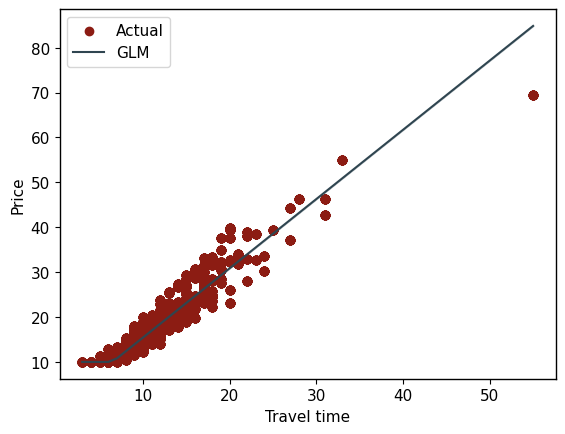

In [143]:
plt.scatter(df["travel_time"], df["price"], label="Actual")
sns.lineplot(x=df["travel_time"], y=np.maximum(df["mean"], 10), color="#2F4550", label="GLM")
# plt.plot(df.loc[df["new_mean"] == 10, "travel_time"], df.loc[df["new_mean"] == 10, "new_mean"], color="#2F4550", label="GLM")
#plt.plot(df["travel_time"], df["travel_time"]*3, color="black", label="RL")
#plt.plot(df["travel_time"], df["travel_time"]*2, color="magenta", label="RL2")
plt.xlabel("Travel time")
plt.ylabel("Price")
plt.legend()
plt.savefig("./figs/reg_with_base.png")
plt.show()

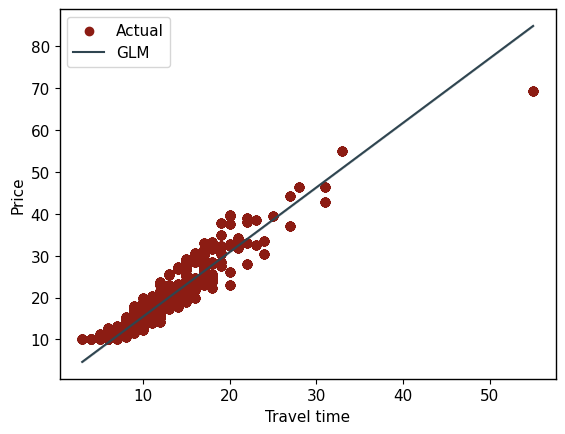

In [145]:
plt.scatter(df["travel_time"], df["price"], label="Actual")
sns.lineplot(x=df["travel_time"], y=df["mean"], color="#2F4550", label="GLM")
#plt.plot(df["travel_time"], df["travel_time"]*3, color="black", label="RL")
#plt.plot(df["travel_time"], df["travel_time"]*2, color="magenta", label="RL2")
plt.xlabel("Travel time")
plt.ylabel("Price")
plt.legend()
plt.savefig("./figs/reg_without_base.png")
plt.show()

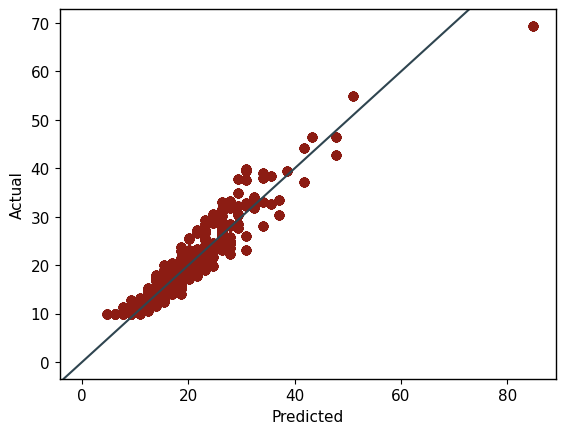

In [136]:
plt.scatter(fitted_glm.predict(), pred_df["price"])
plt.axline((0,0), slope=1, color="#2F4550")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

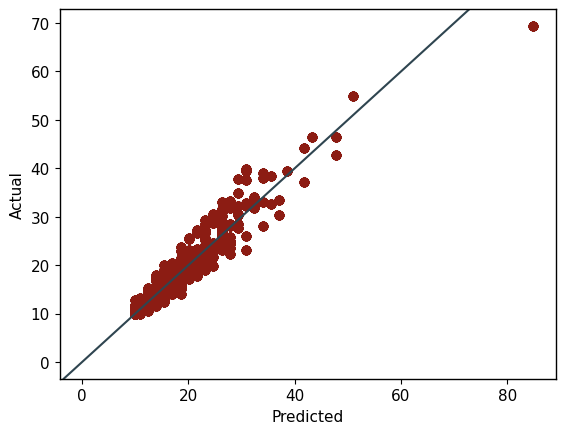

In [141]:
plt.scatter(np.maximum(df["mean"],10), df["price"])
plt.axline((0,0), slope=1, color="#2F4550")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

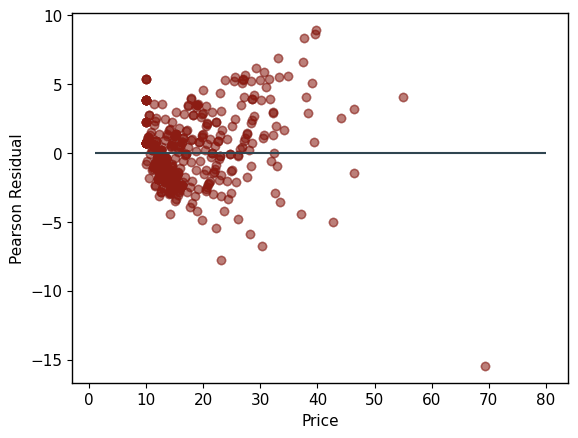

In [147]:
plt.scatter(pred_df["price"], fitted_glm.resid_pearson, alpha=0.05)
plt.hlines(y=0, xmin=1, xmax=80, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.savefig("./figs/res_without_base.png")
plt.show()

In [ ]:
# sns.scatterplot(x=pred_df["price"], y=fitted_glm.resid_pearson)
plt.scatter(pred_df["price"], df["price"] - np.maximum(df["mean"],10), alpha=0.05)
plt.hlines(y=0, xmin=1, xmax=80, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.savefig("./figs/res_with_base.png")
plt.show()

# Predicting demand

In [174]:
def model_2(vars, travel_time):
    alpha, beta = vars
    demand_hat = np.exp(alpha + beta * travel_time)
    return demand_hat

In [175]:
def mse_model2(vars, price, travel_time):
    price_hat = model_2(vars, travel_time)
    return np.mean((price-price_hat)**2)

In [180]:
x0 = (0,0)
res = minimize(mse_model2, x0, args=(df.price, df.travel_time), tol=1e-3, method="Powell")

In [181]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 20.92744780137508
       x: [ 2.447e+00  3.932e-02]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [-2.373e-01  1.697e-02]]
    nfev: 98

In [182]:
res.x

array([2.44746718, 0.03932451])

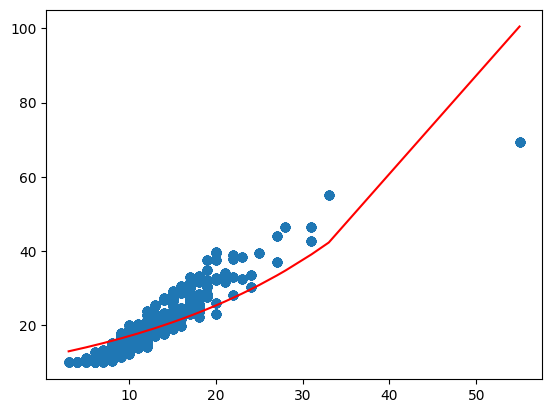

In [183]:
plt.plot(df.travel_time.sort_values(ascending=False).values, model_2(res.x, df.travel_time.sort_values(ascending=False).values), color="red")
plt.scatter(df.travel_time.sort_values(ascending=False).values,df.sort_values("travel_time", ascending=False).price.values)
plt.show()

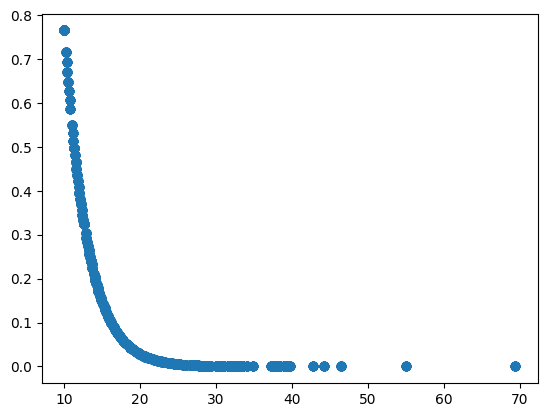

In [108]:
plt.scatter(df["price"], np.exp(res.x[0] + res.x[1] * df["price"]))

In [ ]:
plt.plot(df.price.sort_values(ascending=False).values, model_2(res.x, df.demand.sort_values(ascending=False).values), color="red")
plt.scatter(df.price.sort_values(ascending=False).values,df.sort_values("price", ascending=False).demand.values)